In [8]:
import multiprocessing
import os
from typing import List

import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
from scipy.stats import gmean, spearmanr
from tqdm import tqdm

from utils.misc import plot_scatter_psr2

N_PROCS = multiprocessing.cpu_count() - 1
P_THRESHOLD = -np.log10(0.05)

In [9]:
import qnorm

anno = pd.read_csv("data/experimental/anno.tsv", sep="\t", index_col=0, comment="#")
norms = pd.read_csv("data/experimental/Obx_norms_v.7_2020_11_24.tsv", sep="\t", index_col=0)
samples = pd.concat([
    *[pd.read_csv(f"data/experimental/raw/{sample_txt}", sep="\t", index_col=0)
      for sample_txt in os.listdir("data/experimental/raw/")
      ],
    norms
], axis=1).fillna(0).add(1)
normalized = qnorm.quantile_normalize(samples, ncpus=N_PROCS)

In [10]:
cnrs_to_concat = list()
for tumor_sample_id in anno.index:
    # tumor sample
    tumor_sample = normalized[tumor_sample_id]
    # matched norm sample
    matched_norm_sample_id = anno["matched_norm"][tumor_sample_id]
    matched_norm_sample = normalized[matched_norm_sample_id]
    # avg norm
    tissue = anno["tissue"][tumor_sample_id]
    avg_norm = normalized.filter(like=tissue).apply(gmean, axis=1)
    cnrs_to_concat.extend([
        pd.DataFrame(np.log2(tumor_sample / avg_norm), columns=[tumor_sample_id]),
        pd.DataFrame(np.log2(matched_norm_sample / avg_norm), columns=[matched_norm_sample_id])
    ])
cnrs = pd.concat(cnrs_to_concat, axis=1)
cnrs.to_csv("out/experimental/cnrs.tsv", sep="\t")

In [11]:
cnr_correlations_raw = [
    spearmanr(cnrs[tumor_sample_id], cnrs[anno["matched_norm"][tumor_sample_id]])
    for tumor_sample_id in tqdm(anno.index, desc="Calc CNRs correlations")
]
cnr_correlations = pd.DataFrame(cnr_correlations_raw, index=anno.index)
cnr_correlations.to_csv("out/experimental/cnr_correlations.tsv", sep="\t")

Calc CNRs correlations: 100%|██████████| 8/8 [00:00<00:00, 117.44it/s]


Calc CNRs correlations (inv): 100%|██████████| 36596/36596 [00:16<00:00, 2210.02it/s]


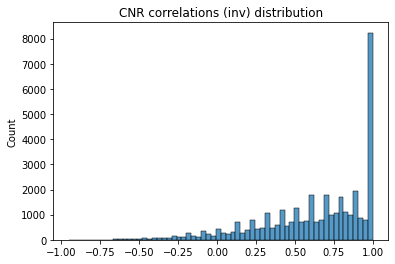

/home/xvvvx/venvs/oncobox/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


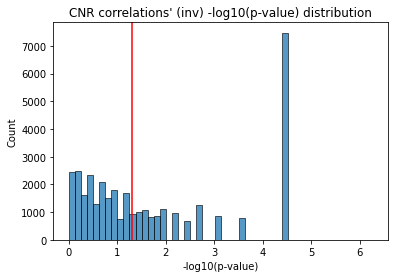

In [12]:
tumor_cnrs = cnrs.filter(anno.index)
normal_cnrs = cnrs.filter([anno["matched_norm"][tumor_sample_id] for tumor_sample_id in anno.index])

assert all([
    anno["matched_norm"][tumor_column] == matched_norm
    for tumor_column, matched_norm in zip(tumor_cnrs.columns, normal_cnrs.columns)
])

zipped_cnrs = zip(tumor_cnrs.values.tolist(), normal_cnrs.values.tolist())
cnr_correlations_inv_raw = [
    spearmanr(_cnrs[0], _cnrs[1])
    for _cnrs in tqdm(zipped_cnrs, total=len(tumor_cnrs), desc="Calc CNRs correlations (inv)")
]
cnr_inv_correlations = pd.DataFrame(cnr_correlations_inv_raw, index=normalized.index)
cnr_inv_correlations.to_csv("out/experimental/cnr_correlations(inv).tsv", sep="\t")

seaborn.histplot(cnr_inv_correlations["correlation"].values)
plt.title("CNR correlations (inv) distribution")
plt.show()

seaborn.histplot(-np.log10(cnr_inv_correlations["pvalue"]), bins=50)
plt.title("CNR correlations' (inv) -log10(p-value) distribution")
plt.xlabel("-log10(p-value)")
plt.axvline(x=P_THRESHOLD, color="red")
plt.show()


In [13]:
from sh import Command
import tempfile


def calc_pals(sample_id: str, norm_samples_ids: List[str]) -> pd.DataFrame:
    with tempfile.TemporaryDirectory() as tmp_dir:
        pals_in_df = normalized.filter([sample_id, *norm_samples_ids], axis=1)
        pals_in_df = pals_in_df.rename(columns={
            sample_id: "Tumor",
            **{x: f"Norm_{i}" for i, x in enumerate(norm_samples_ids)}
        })
        pals_in_df_path = os.path.join(tmp_dir, "pals_in.tsv")
        pals_in_df.to_csv(pals_in_df_path, sep="\t")

        oncobox_calc_score = Command("oncoboxlib_calculate_scores")
        pals_out_df_path = os.path.join(tmp_dir, "pals_out.csv")
        oncobox_calc_score([
            "--databases-dir=/home/xvvvx/oncobox/data/pathways/",
            f"--samples-file={pals_in_df_path}",
            f"--results-file={pals_out_df_path}"
        ])
        pals_out_df = pd.read_csv(pals_out_df_path, index_col=0)
        pals_out_df = pals_out_df.rename(columns=lambda x: {"Tumor": sample_id}.get(x, x))
        return pals_out_df.filter([sample_id])


pals_to_concat = list()
for tumor_sample_id in tqdm(anno.index, desc="Calc PALs"):
    # tumor sample
    tumor_sample = normalized[tumor_sample_id]
    # matched norm sample
    matched_norm_sample_id = anno["matched_norm"][tumor_sample_id]
    matched_norm_sample = normalized[matched_norm_sample_id]
    # avg norm
    tissue = anno["tissue"][tumor_sample_id]
    avg_norm = normalized.filter(like=tissue)
    pals_to_concat.extend([
        calc_pals(tumor_sample_id, avg_norm.columns),
        calc_pals(matched_norm_sample_id, avg_norm.columns),
    ])
pals = pd.concat(pals_to_concat, axis=1)
pals.to_csv("out/experimental/pals.tsv", sep="\t")

Calc PALs: 100%|██████████| 8/8 [00:34<00:00,  4.36s/it]


In [14]:
pal_values = [
    (pals[tumor_sample_id], pals[anno["matched_norm"][tumor_sample_id]])
    for tumor_sample_id in tqdm(anno.index, desc="Calc PALs correlations")
]
pal_correlations = pd.DataFrame([spearmanr(*values) for values in pal_values], index=anno.index)
pal_correlations.to_csv("out/experimental/pal_correlations.tsv", sep="\t")

Calc PALs correlations: 100%|██████████| 8/8 [00:00<00:00, 8692.86it/s]


Calc PALs correlations (inv):  24%|██▎       | 719/3044 [00:00<00:00, 2407.30it/s]/home/xvvvx/venvs/oncobox/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
Calc PALs correlations (inv): 100%|██████████| 3044/3044 [00:01<00:00, 2092.09it/s]


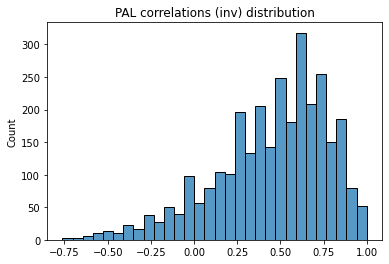

/home/xvvvx/venvs/oncobox/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


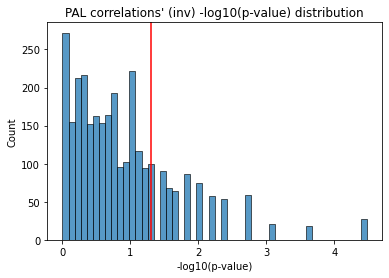

In [15]:
tumor_pals = pals.filter(anno.index)
normal_pals = pals.filter([anno["matched_norm"][tumor_sample_id] for tumor_sample_id in anno.index])

assert all([
    anno["matched_norm"][tumor_column] == matched_norm
    for tumor_column, matched_norm in zip(tumor_cnrs.columns, normal_cnrs.columns)
])

zipped_pals = zip(tumor_pals.values.tolist(), normal_pals.values.tolist())
pal_correlations_inv_raw = [
    spearmanr(*values) for values in tqdm(zipped_pals, total=len(tumor_pals), desc="Calc PALs correlations (inv)")
]
pal_inv_correlations = pd.DataFrame(pal_correlations_inv_raw, index=pals.index)
pal_inv_correlations.to_csv("out/experimental/pal_correlations(inv).tsv", sep="\t")

seaborn.histplot(pal_inv_correlations["correlation"].values)
plt.title("PAL correlations (inv) distribution")
plt.show()

seaborn.histplot(-np.log10(pal_inv_correlations["pvalue"]), bins=50)
plt.title("PAL correlations' (inv) -log10(p-value) distribution")
plt.xlabel("-log10(p-value)")
plt.axvline(x=P_THRESHOLD, color="red")
plt.show()

Index(['LEN1_S9_R1_001', 'LSN1_S7_R1_001', 'MN-9_S2_ME_L001_R1_001',
       'MN-1_S8_ME_L001_R1_001', 'MN-2_S9_ME_L001_R1_001',
       'MN-6_S1_ME_L001_R1_001', 'CC_87_S8_R1_001',
       'CC101_S10_ME_L001_R1_001'],
      dtype='object')


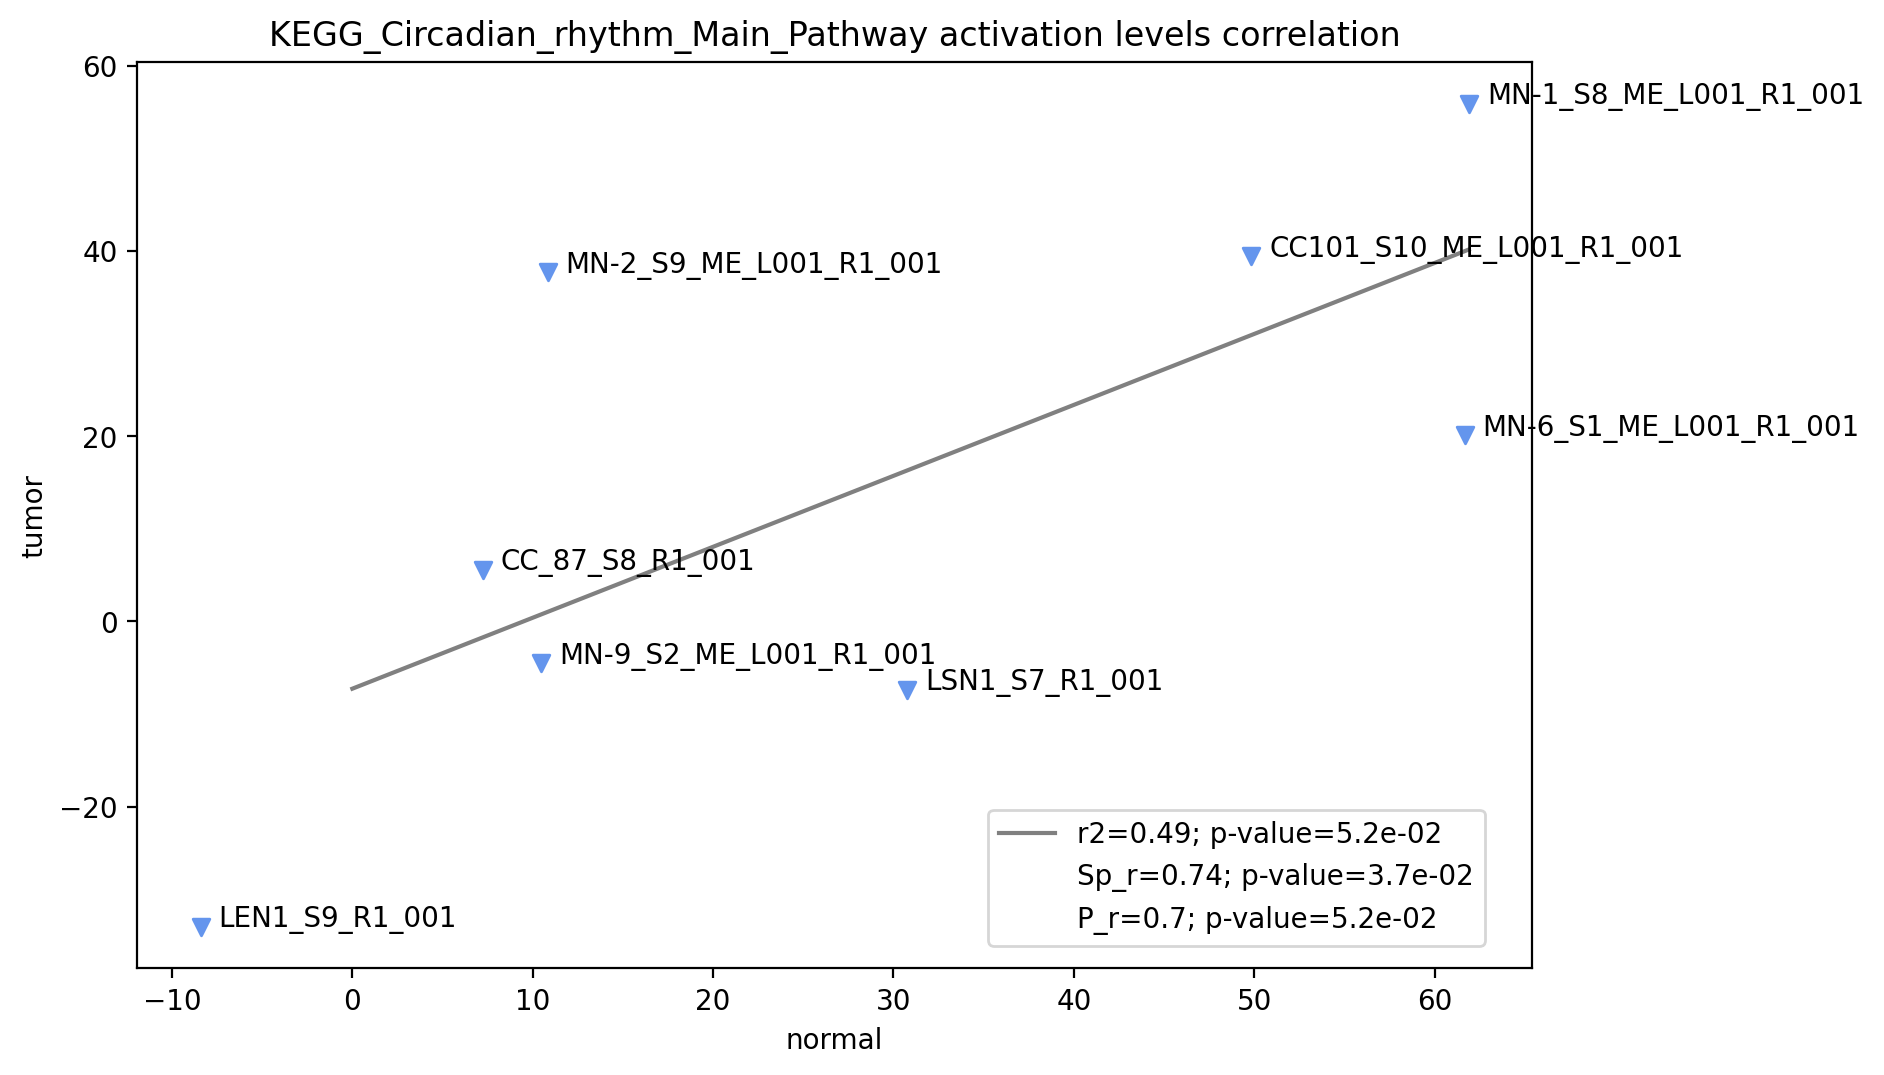

In [16]:
significant_pathways = [
    "KEGG_Circadian_rhythm_Main_Pathway",
]

for pathway in significant_pathways:
    print(tumor_pals.columns)
    plot_scatter_psr2(
        pd.DataFrame({
            "tumor": tumor_pals.T[pathway].values,
            "normal": normal_pals.T[pathway].values
        }),
        x="normal",
        y="tumor",
        title=f"{pathway} activation levels correlation",
        labels=list(tumor_pals.columns)
    )